In [2]:
import pandas as pd 
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns

# Linear regression notebook

In [3]:
train = pd.read_csv('train.csv')
train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


### Cleaning up our data and making it save memory

In [4]:
# 🧹 Function to reduce memory usage of a Pandas DataFrame

def reduce_mem_usage(df):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    # 📏 Calculate the initial memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2

    # 🔄 Iterate through each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype

        # Check if the column's data type is not 'object' (i.e., numeric)
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # Check if the column's data type is a float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    return df


train = reduce_mem_usage(train)

# Understanding and visualizing the structure of our data 

1. Understanding all the data types we have 
2. Basic statistics about the data 
3. Visualizing the distributions of the data 
4. Looking for correlations in the data 
5. Experimenting with attribute combinations 

##

### Data types 

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int16  
 1   date_id                  int16  
 2   seconds_in_bucket        int16  
 3   imbalance_size           float32
 4   imbalance_buy_sell_flag  int8   
 5   reference_price          float32
 6   matched_size             float32
 7   far_price                float32
 8   near_price               float32
 9   bid_price                float32
 10  bid_size                 float32
 11  ask_price                float32
 12  ask_size                 float32
 13  wap                      float32
 14  target                   float32
 15  time_id                  int16  
 16  row_id                   object 
dtypes: float32(11), int16(4), int8(1), object(1)
memory usage: 304.7+ MB


### Basic statistics

In [6]:
non_id_columns = [col for col in train.columns if not col.endswith('id')]
train[non_id_columns].describe()


,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
count,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06
mean,2.700000e+02,5.715294e+06,-1.189619e-02,9.999961e-01,4.510024e+07,1.001713e+00,9.996603e-01,9.997261e-01,5.181356e+04,1.000264e+00,5.357570e+04,9.999929e-01,-4.756123e-02
std,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00
min,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02
25%,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279576e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00
50%,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02
75%,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00
max,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02


### Visualizing the distributions of the data 

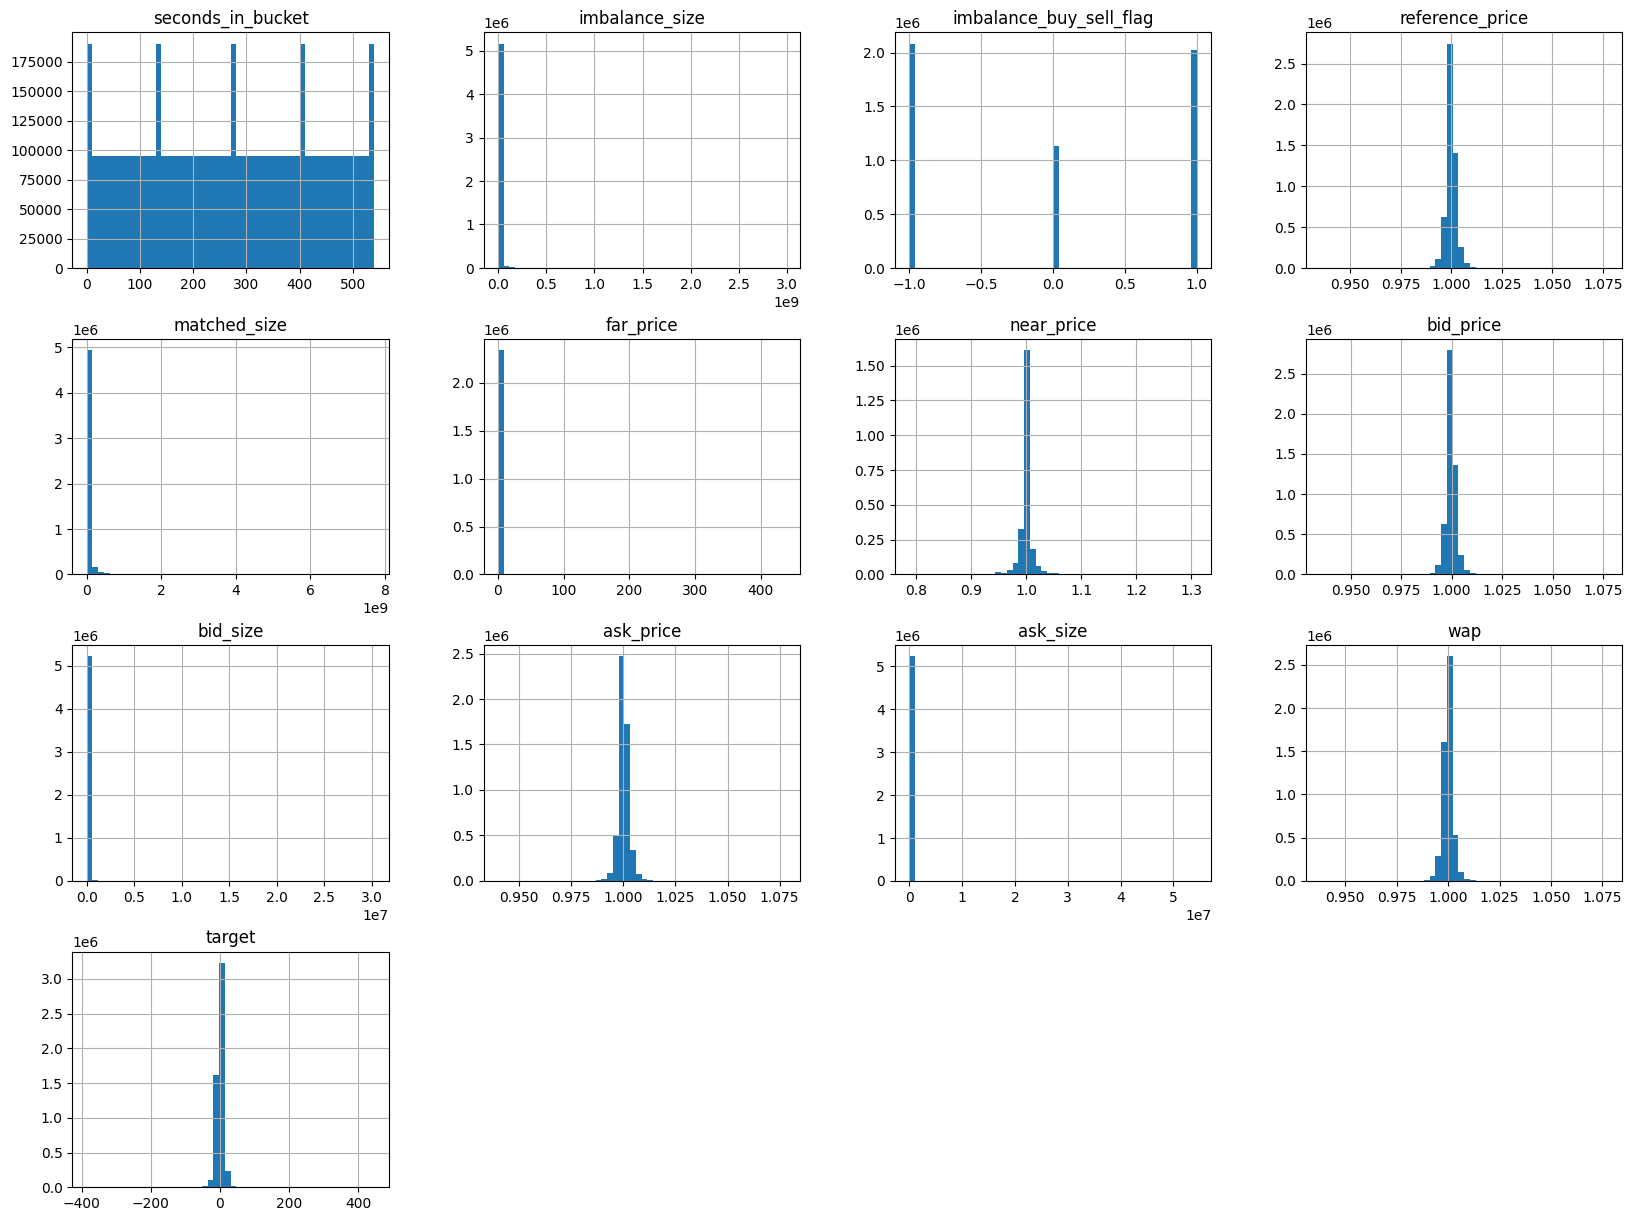

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
train[non_id_columns].hist(bins=50, figsize=(20,15))
plt.show()

### Looking for correlations in the data 

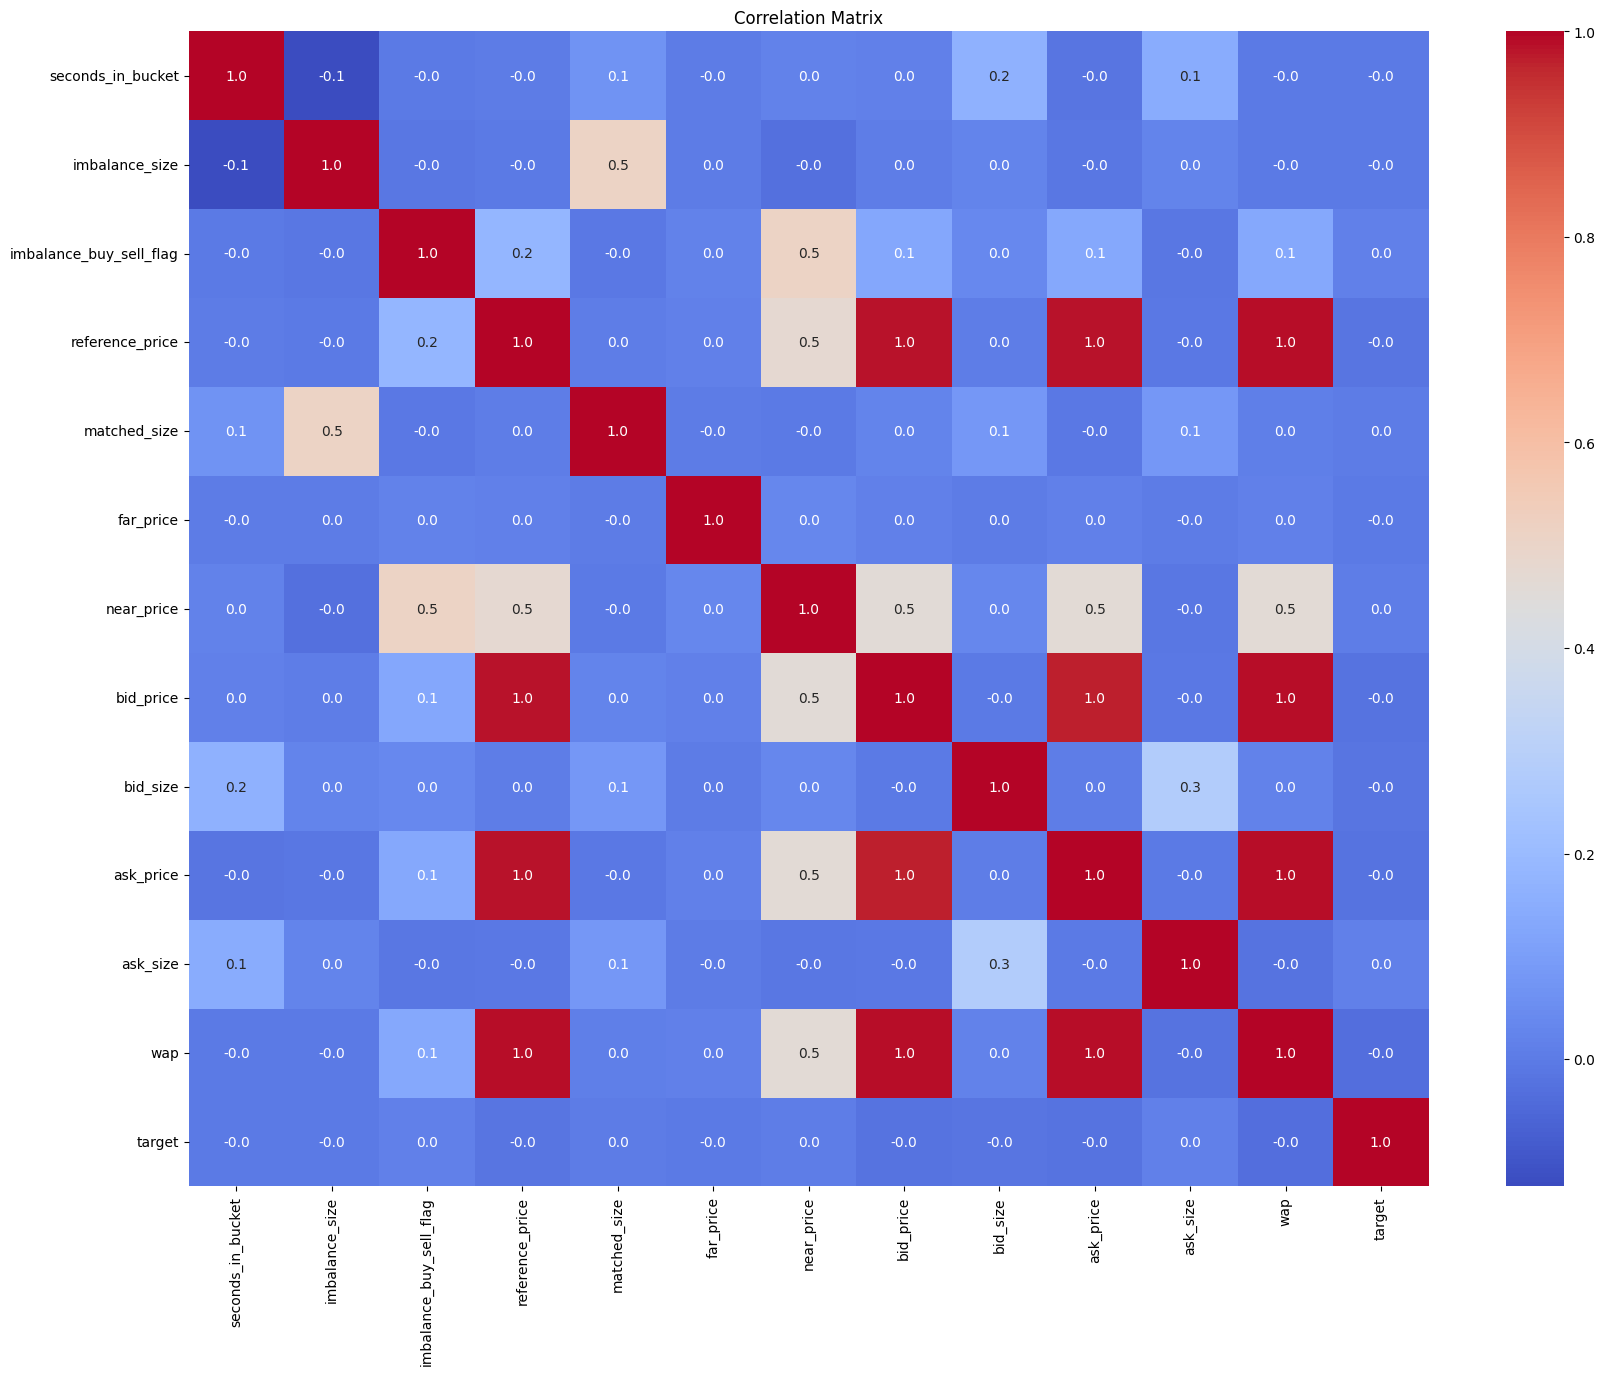

In [8]:
%matplotlib inline
corr_matrix = train[non_id_columns].corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation Matrix')
plt.show()



In [11]:
corr_matrix['target'].sort_values(ascending=False)

target                     1.000000
imbalance_buy_sell_flag    0.015102
ask_size                   0.014936
near_price                 0.006045
matched_size               0.000197
imbalance_size            -0.001190
far_price                 -0.001804
seconds_in_bucket         -0.002203
reference_price           -0.017394
bid_size                  -0.018000
ask_price                 -0.021674
bid_price                 -0.022326
wap                       -0.035165
Name: target, dtype: float64

### Handling null values for the data

In [27]:
#how many columns have missing values 
count_null_rows = train.isnull().any().sum(axis=0)
total_rows = train.shape[0]

ratio = count_null_rows/total_rows
print(ratio)
if ratio < 0.05:
    train.dropna(inplace=True)
else:
    for col in train.columns:
        median = train[col].median()
        train[col].fillna(median, inplace=True)





0.0


### Data engineering

In [31]:
train['imbalance_flagxsize'] = train['imbalance_buy_sell_flag']*train['imbalance_buy_sell_flag']
train["spread"] = train["ask_price"]-train["bid_price"]
train["mid_price"] = (train["ask_price"]+train["bid_price"])/2
train["liquidity_imbalance"] = (train["bid_price"]-train['ask_price'])/(train["bid_price"]+train['ask_price'])
train["volume"] = train["bid_size"]+train['ask_size']
prices = ['bid_price', 'ask_price', 'mid_price', 'spread', 'reference_price', 'far_price', 'near_price', 'wap']

for func in ["mean", "std", "skew"]:
    train[f'all_prices{func}'] = train[prices].agg(func, axis=1)




train.head()



,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,mid_price_std,all_pricesskew,reference_price_skew,far_price_skew,near_price_skew,bid_price_skew,ask_price_skew,wap_skew,spread_skew,mid_price_skew
5730,0,0,300,0.000000e+00,0,1.000241,26670118.00,1.000241,1.000241,1.000026,...,0.002001,-2.828427,0.603998,0.581829,0.421215,0.534294,1.174692,0.967287,2.562867,0.868169
5731,1,0,300,2.423330e+05,-1,1.000073,3242054.25,0.981974,0.994490,0.999544,...,0.002001,-2.826633,0.603998,0.581829,0.421215,0.534294,1.174692,0.967287,2.562867,0.868169
5732,2,0,300,0.000000e+00,0,1.000193,4671376.00,1.000193,1.000193,0.999035,...,0.002001,-2.828412,0.603998,0.581829,0.421215,0.534294,1.174692,0.967287,2.562867,0.868169
5733,3,0,300,2.914730e+06,1,0.999870,41057776.00,1.003870,1.002279,0.999827,...,0.002001,-2.828327,0.603998,0.581829,0.421215,0.534294,1.174692,0.967287,2.562867,0.868169
5734,4,0,300,3.396923e+06,1,0.998496,38356176.00,1.007894,1.007894,0.998357,...,0.002001,-2.827619,0.603998,0.581829,0.421215,0.534294,1.174692,0.967287,2.562867,0.868169


# Cleaning the data
1. Handling null values
2. Feature scaling 

### Feature scaling

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


data_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('std_scaler', StandardScaler())])




# Test set selection

If your data is not large enough then you would want to be careful about how you sample for the test set. If our test set is incorrectly samples that leads to issues when you're training your model as it's easy to introduce a sample selection bias (probabilistically). If you see below we have around 2 million different data points, so it's say to say that we can run with a regular test set selection as we need.

In [23]:
train.shape[0]

2343638

In [32]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

# Evaluating several models on this data for our own understanding.

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [34]:
lin_reg = LinearRegression()
lin_reg.fit(train_df.drop(['target','time_id'], axis=1), train_df['target'])
target_predictions = lin_reg.predict(val_df.drop(['target','time_id'], axis=1))
lin_mae = mean_absolute_error(val_df['target'], target_predictions)
lin_mae

5.651013059356383